In [2]:
#先引入后面可能用到的包（package）
import pandas as pd  
import numpy as np
from scipy import stats
import tushare as ts 
import matplotlib.pyplot as plt
%matplotlib inline   

#正常显示画图时出现的中文和负号
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

In [3]:
#使用之前先输入token，可以从个人主页上复制出来，每次调用数据需要先运行该命令
token='e0eeb08befd1f07516df2cbf9cbd58663f77fd72f92a04f290291c9d'
ts.set_token(token)
pro=ts.pro_api()

In [6]:
from dateutil.parser import parse
from datetime import datetime,timedelta
#获取交易日历
cals=pro.trade_cal(exchange='')
cals=cals[cals.is_open==1].cal_date.values
def trans_date(date):
    while date not in cals:
        t=parse(date)
        date=(t-timedelta(1)).strftime('%Y%m%d')
    return date
def get_code():
    df = pro.stock_basic(list_status='L')
    codes=df.ts_code.values
    names=df.name.values
    stock=dict(zip(codes,names))
    return stock
def get_daily_data(n=300):
    t=datetime.now()
    if t.hour>18:
        t0=t.strftime('%Y%m%d')
    else:
        t0=(t-timedelta(1)).strftime('%Y%m%d')
    t1=trans_date(t0)
    n0=np.argwhere(cals==t1)[0][0]+1
    dates=cals[:n0][-n:]
    df=pro.daily(trade_date=dates[0])
    for d in dates[1:]:
        df1=pro.daily(trade_date=d)
        df=pd.concat([df,df1])
    return df

In [7]:
df=get_daily_data(n=300)
df_new=df.set_index(['trade_date','ts_code'])['close']
df_new.head(10)
#数据重排，列名为代码
data=df_new.unstack()
data.rename(columns=get_code(),inplace=True)
data.head()

ts_code,平安银行,万科A,国农科技,世纪星源,深振业A,全新好,神州高铁,中国宝安,*ST美丽,深物业A,...,南微医学,天宜上佳,航天宏图,虹软科技,晶晨股份,西部超导,柏楚电子,微芯生物,铂力特,嘉元科技
trade_date,,,,,,,,,,,,,,,,,,,,,
20180615,10.17,27.99,19.85,3.11,6.89,NaN,NaN,5.40,3.95,13.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20180619,9.87,27.10,19.22,2.80,6.20,NaN,NaN,4.86,3.79,12.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20180620,9.91,26.96,19.15,2.90,6.19,NaN,NaN,4.85,4.02,12.09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20180621,9.86,27.73,18.83,2.91,6.12,NaN,NaN,4.71,4.05,11.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20180622,9.85,28.10,19.03,2.93,5.99,NaN,NaN,4.84,4.01,11.41,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#剔除次新股和st股票
def get_new_code():
    df = pro.stock_basic(exchange='', list_status='L')
    #剔除2017年以后上市的新股次新股
    df=df[df['list_date'].apply(int).values<20170101]
    #剔除st股
    df=df[-df['name'].apply(lambda x:x.startswith('*ST'))]
    df=df[-df['name'].apply(lambda x:x.startswith('ST'))]
    #将剩下的股票代码和名称映射为字典
    codes=df.ts_code.values
    names=df.name.values
    stock=dict(zip(names,codes))
    return stock
new_codes=list(set(data.columns).intersection(set(get_new_code().keys())))
data_new=data[new_codes]
data_new.head()

ts_code,金浦钛业,慈星股份,三川智慧,邦宝益智,凯文教育,搜于特,奋达科技,华灿光电,新大陆,福成股份,...,美吉姆,华谊嘉信,广东鸿图,北玻股份,国金证券,杭齿前进,三丰智能,合肥城建,海汽集团,漫步者
trade_date,,,,,,,,,,,,,,,,,,,,,
20180615,NaN,6.37,3.79,16.53,13.57,3.59,9.85,14.67,16.24,10.70,...,NaN,3.57,9.01,3.26,7.70,6.67,12.26,11.92,9.63,7.13
20180619,NaN,5.79,3.44,14.88,13.10,3.45,8.87,13.60,14.73,10.60,...,NaN,3.21,8.48,2.97,6.99,6.19,11.42,10.73,8.67,6.47
20180620,NaN,5.93,3.50,14.71,13.15,3.49,8.85,13.52,15.17,10.42,...,NaN,3.53,8.55,3.10,7.03,6.19,11.65,10.73,9.40,6.59
20180621,NaN,5.77,3.42,15.30,13.00,3.45,8.40,12.85,14.91,10.22,...,NaN,3.52,8.60,3.06,6.69,6.07,11.31,10.10,9.02,6.28
20180622,NaN,5.85,3.47,15.37,13.35,3.47,8.63,12.81,15.13,10.19,...,NaN,3.48,8.62,3.10,6.82,6.18,11.64,10.42,9.11,6.43


In [12]:
final_data=data_new.dropna(axis=1)
final_data.tail()

ts_code,慈星股份,三川智慧,邦宝益智,凯文教育,搜于特,奋达科技,新大陆,福成股份,万安科技,中交地产,...,黑猫股份,中航三鑫,华谊嘉信,广东鸿图,北玻股份,国金证券,杭齿前进,三丰智能,海汽集团,漫步者
trade_date,,,,,,,,,,,,,,,,,,,,,
20190829,5.28,4.59,9.29,7.50,2.37,4.35,17.45,9.37,6.98,6.47,...,4.96,4.88,3.17,6.90,2.74,8.87,11.97,9.52,6.27,6.24
20190830,5.14,4.52,9.06,7.30,2.31,4.21,17.16,9.17,6.97,6.25,...,4.92,5.00,3.06,6.66,2.68,8.78,11.34,9.32,6.19,5.99
20190902,5.17,4.61,9.21,7.70,2.38,4.33,17.62,9.15,7.05,6.33,...,4.99,5.07,3.10,6.73,2.75,8.94,11.54,9.66,6.24,6.40
20190903,5.13,4.65,9.28,7.68,2.37,4.40,17.63,9.10,7.06,6.32,...,5.00,5.11,3.08,6.74,2.75,8.90,11.41,9.69,6.22,6.47
20190904,5.12,4.69,9.29,7.60,2.39,4.48,17.58,9.09,7.11,6.59,...,5.01,5.10,3.08,6.78,2.78,9.00,11.17,9.85,6.31,6.48


In [30]:
final_data.corr()

ts_code,慈星股份,三川智慧,邦宝益智,凯文教育,搜于特,奋达科技,新大陆,福成股份,万安科技,中交地产,...,黑猫股份,中航三鑫,华谊嘉信,广东鸿图,北玻股份,国金证券,杭齿前进,三丰智能,海汽集团,漫步者
ts_code,,,,,,,,,,,,,,,,,,,,,
慈星股份,1.000000,0.756323,0.433446,-0.034682,0.345737,0.278549,0.679325,0.294054,0.646856,0.150996,...,-0.238495,0.486394,0.027420,0.018429,0.400401,0.650403,0.460415,0.013551,0.175915,0.412670
三川智慧,0.756323,1.000000,0.203454,-0.401434,0.037537,0.036726,0.823073,0.190707,0.496171,-0.077782,...,-0.596240,0.489602,-0.013086,-0.012861,0.262497,0.832359,0.726243,0.009637,-0.126639,0.242778
邦宝益智,0.433446,0.203454,1.000000,0.579755,0.722670,0.577385,0.192028,0.482302,0.696565,0.680662,...,0.379865,0.547940,0.291968,0.331730,0.593811,0.072941,-0.199625,0.400099,0.657290,0.527877
凯文教育,-0.034682,-0.401434,0.579755,1.000000,0.743102,0.637461,-0.280553,0.269075,0.383689,0.629695,...,0.849128,0.187422,0.226343,0.260683,0.446052,-0.468549,-0.589541,0.314814,0.782421,0.569440
搜于特,0.345737,0.037537,0.722670,0.743102,1.000000,0.637597,0.090617,0.624742,0.743998,0.750142,...,0.653571,0.532841,0.378806,0.423850,0.715777,0.000958,-0.270992,0.459930,0.766377,0.690990
奋达科技,0.278549,0.036726,0.577385,0.637461,0.637597,1.000000,0.225153,0.243073,0.582748,0.685663,...,0.443930,0.509498,0.338467,0.453160,0.534477,0.053574,-0.080164,0.436698,0.812744,0.687040
新大陆,0.679325,0.823073,0.192028,-0.280553,0.090617,0.225153,1.000000,0.264844,0.606550,0.039354,...,-0.406281,0.669672,0.232992,0.326502,0.490043,0.915643,0.822527,0.307270,0.120478,0.468470
福成股份,0.294054,0.190707,0.482302,0.269075,0.624742,0.243073,0.264844,1.000000,0.689438,0.606063,...,0.405376,0.656787,0.530883,0.653076,0.765167,0.351374,0.012664,0.596653,0.466242,0.407059
万安科技,0.646856,0.496171,0.696565,0.383689,0.743998,0.582748,0.606550,0.689438,1.000000,0.581277,...,0.277477,0.818302,0.528957,0.581346,0.881065,0.527124,0.254875,0.517335,0.672594,0.794198


In [25]:
dd=final_data.iloc[:,:5]
dd.head()

ts_code,慈星股份,三川智慧,邦宝益智,凯文教育,搜于特
trade_date,,,,,
20180615,6.37,3.79,16.53,13.57,3.59
20180619,5.79,3.44,14.88,13.10,3.45
20180620,5.93,3.50,14.71,13.15,3.49
20180621,5.77,3.42,15.30,13.00,3.45
20180622,5.85,3.47,15.37,13.35,3.47


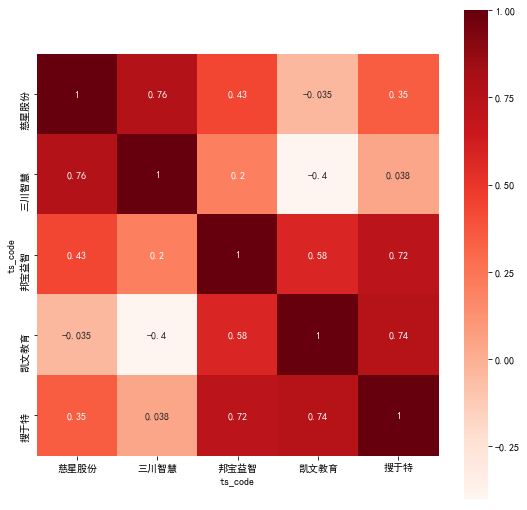

In [27]:
#皮尔逊相关系数
import seaborn as sns
d1=dd.corr()
plt.subplots(figsize=(9, 9)) # 设置画面大小
sns.heatmap(d1, annot=True, vmax=1, square=True, cmap="Reds")
plt.show()

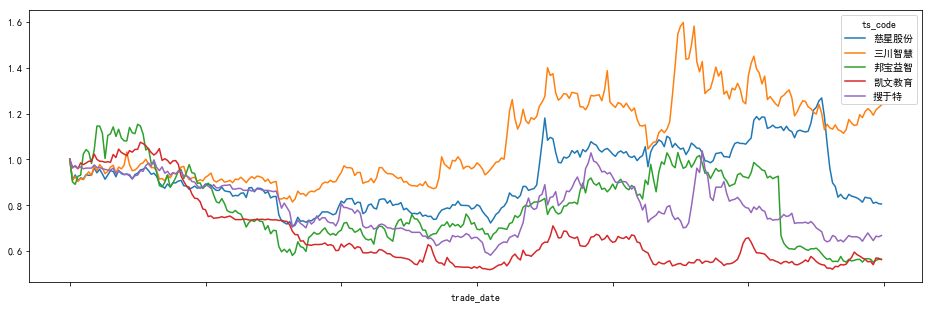

In [29]:
(dd/dd.iloc[0]).plot(figsize=(16,5))
plt.show()